In [12]:
import pandas as pd

# Load the dataset
file_path = '../inputs/dataset_1.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,x,y,label
0,-40.89014,19.53383,1.0
1,78.65134,-41.45239,0.0
2,22.76285,19.44897,1.0
3,69.00952,2.82944,1.0
4,69.45695,9.89498,1.0


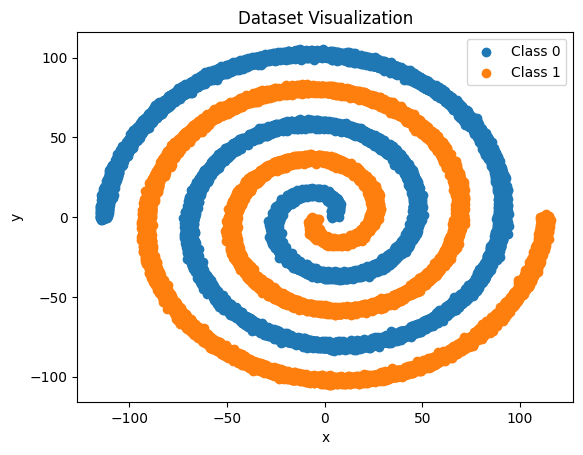

In [13]:
import matplotlib.pyplot as plt

# Plot the dataset
plt.scatter(data[data['label'] == 0]['x'], data[data['label'] == 0]['y'], label='Class 0')
plt.scatter(data[data['label'] == 1]['x'], data[data['label'] == 1]['y'], label='Class 1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Dataset Visualization')
plt.show()

In [14]:
from sklearn.model_selection import train_test_split

# Shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)

# Split the dataset into 50 subsets
subsets = []
num_subsets = 50
subset_size = len(data) // num_subsets

for i in range(num_subsets):
    subset = data.iloc[i*subset_size:(i+1)*subset_size]
    subsets.append(subset)

# Ensure each class has an equal number of samples in each subset
for subset in subsets:
    class_0 = subset[subset['label'] == 0]
    class_1 = subset[subset['label'] == 1]
    min_size = min(len(class_0), len(class_1))
    subset_balanced = pd.concat([class_0.iloc[:min_size], class_1.iloc[:min_size]])
    subsets[i] = subset_balanced

# Split each subset into training and testing sets (2:8 ratio)
train_subsets = []
test_subsets = []

for subset in subsets:
    train, test = train_test_split(subset, test_size=0.8, stratify=subset['label'])
    train_subsets.append(train)
    test_subsets.append(test)


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [16]:
class GRUOptimizer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUOptimizer, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        x, h = self.gru(x, h)
        x = self.fc(x[:, -1, :])
        return x, h

In [20]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Function to flatten gradients
def get_flat_grads(grads):
    return torch.cat([g.view(-1) for g in grads if g is not None])

# Determine the number of parameters in the MLP
dummy_mlp = MLP(input_size, hidden_size, output_size)
num_params = sum(p.numel() for p in dummy_mlp.parameters())

# Updated GRUOptimizer to match the flattened gradient size
class GRUOptimizer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUOptimizer, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        x, h = self.gru(x, h)
        x = self.fc(x[:, -1, :])
        return x, h

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 128
gru_optimizer = GRUOptimizer(num_params, hidden_size, num_params).to(device)
criterion = nn.MSELoss()
gru_optimizer_optim = optim.Adam(gru_optimizer.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    for train_subset in train_subsets:
        ff = MLP(input_size, hidden_size, output_size).to(device)  # Reinitialize ff for each subset
        ff_optim = optim.Adam(ff.parameters(), lr=0.001)
        
        # Prepare training data
        train_x = torch.tensor(train_subset[['x', 'y']].values, dtype=torch.float32).to(device)
        train_y = torch.tensor(train_subset['label'].values, dtype=torch.float32).to(device)
        
        h = torch.zeros(1, 1, hidden_size).to(device)  # Initial hidden state for GRU
        
        for i in range(len(train_x)):
            ff_output = ff(train_x[i].unsqueeze(0))
            loss = criterion(ff_output, train_y[i].unsqueeze(0).view(-1, 1))
            ff_optim.zero_grad()
            loss.backward()
            ff_optim.step()
            
            # Update GRU optimizer
            grads = [param.grad for param in ff.parameters()]
            flat_grads = get_flat_grads(grads).view(1, 1, -1).to(device)  # Adjust the shape to fit GRU input
            _, h = gru_optimizer(flat_grads, h)

# Save the trained model
torch.save(gru_optimizer.state_dict(), 'gru_optimizer.pth')


/home/reza/.local/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/reza/.local/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/reza/.local/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  